In [142]:
from matplotlib import pyplot as plt
import torch
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from models import conv_relu, train, DEFAULT_DEVICE
from dataset import load_dataset
from visualization import classes_to_image, high_dimensional_to_rgb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def show_example(x, y, prediction=None):
    cols = 2 if prediction is None else 3
    
    plt.subplot(1, cols, 1)
    plt.title('Satellite image')
    plt.axis('off')
    plt.imshow(high_dimensional_to_rgb(np.array(x)))
    
    plt.subplot(1, cols, 2)
    plt.title('Reference marking')
    plt.axis('off')
    plt.imshow(classes_to_image(np.array(y)))
    
    if prediction is not None:
        plt.subplot(1, 3, 3)
        plt.title('Model output')
        plt.axis('off')
        plt.imshow(classes_to_image(np.array(prediction)))
    
    plt.show()
    
def to_numpy(a):
    return a.detach().numpy()

# Load dataset and visualize random examples

In [138]:
d = load_dataset("dataset.hdf5", normalize=True)

/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


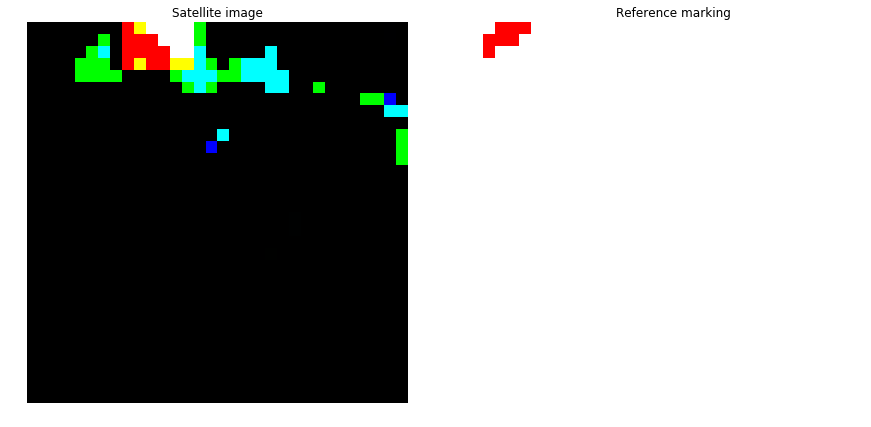

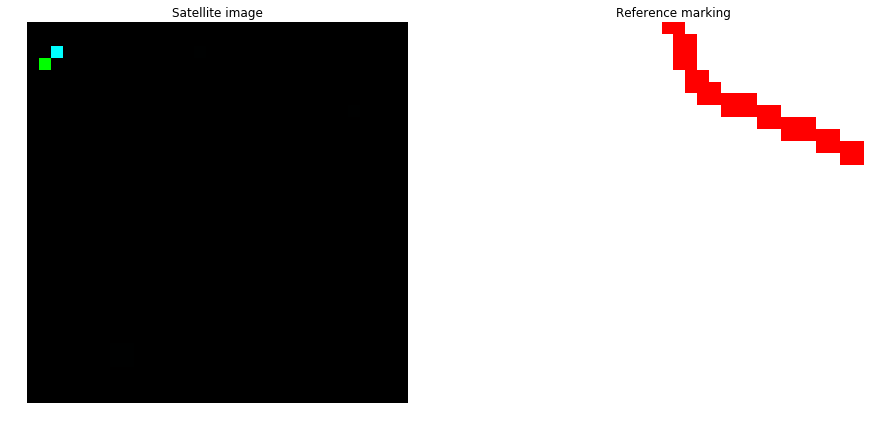

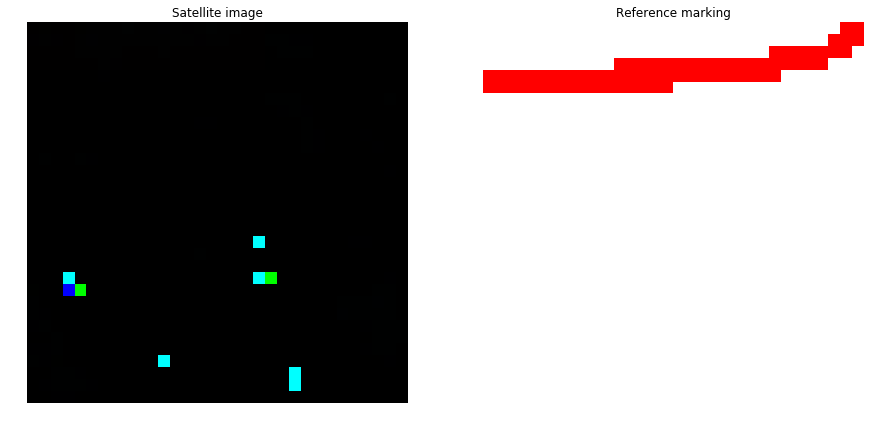

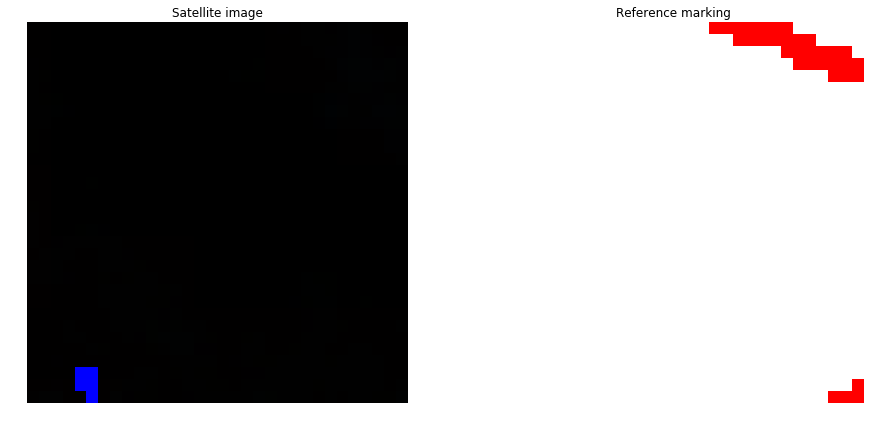

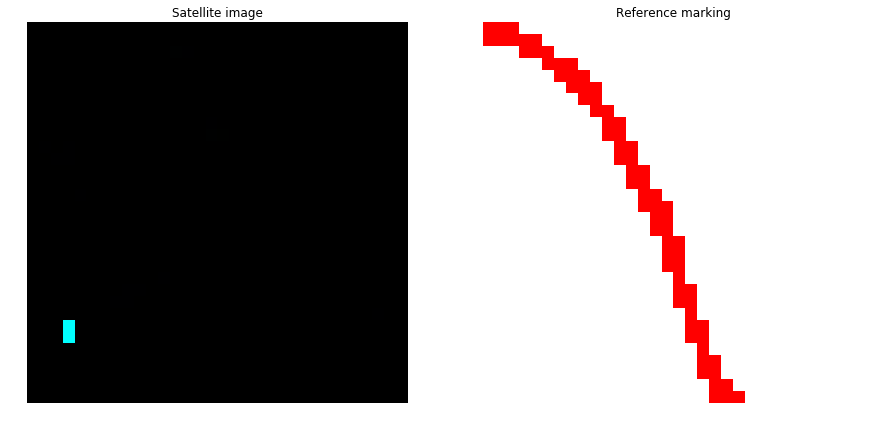

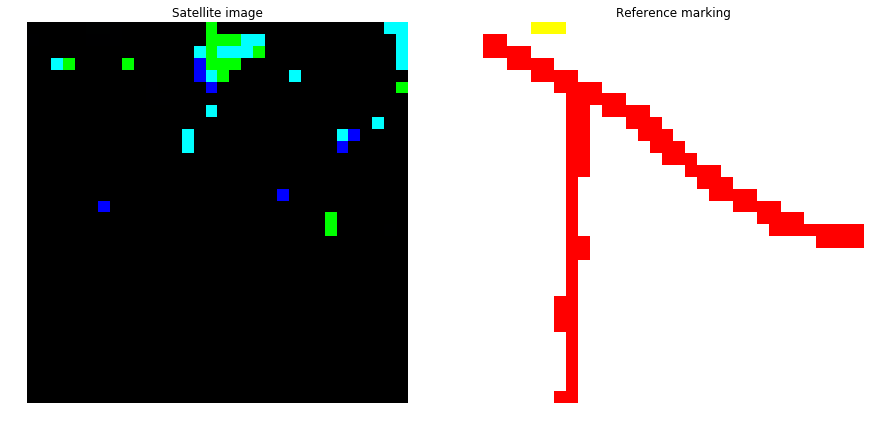

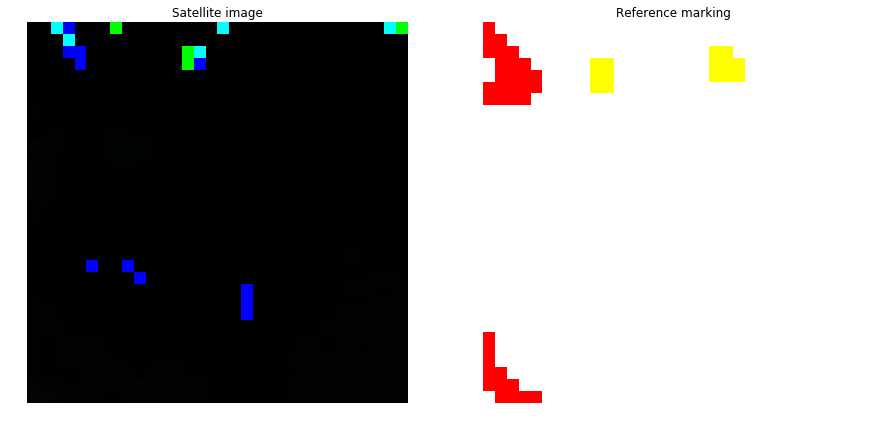

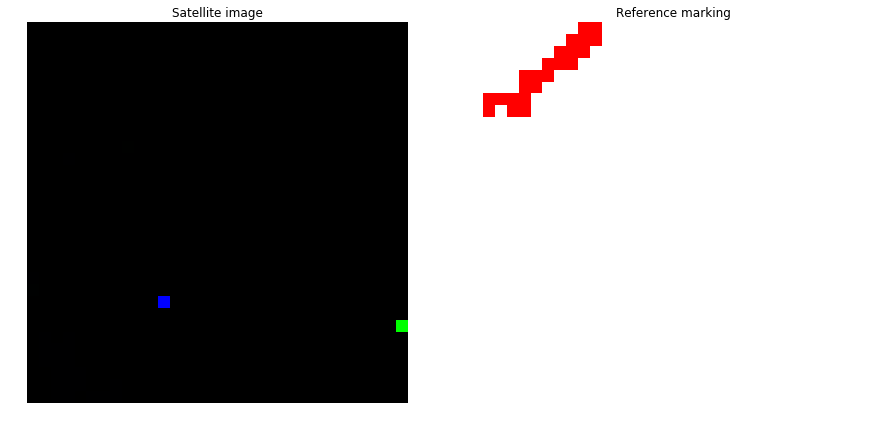

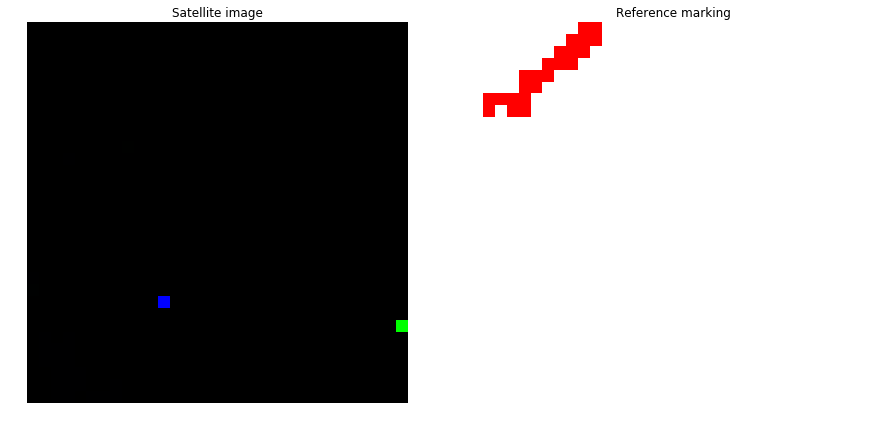

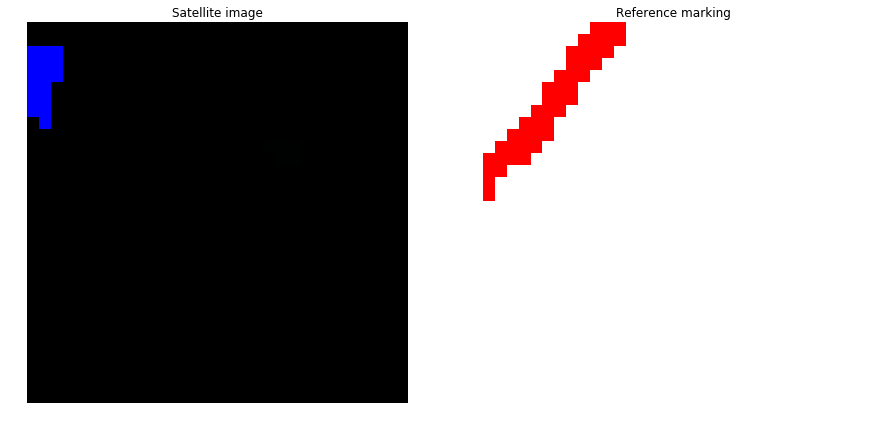

In [139]:
EXAMPLES = 10

while EXAMPLES > 0:
    idx = np.random.randint(0, len(d.train))
    (x, y) = d.train[idx]
    
    if (np.array(y).argmax(axis=0) == 1).sum() == 0:
        continue
      
    show_example(x, y)
    EXAMPLES -= 1

# Create and train model

In [159]:
model = conv_relu(d.input_bands, 3, n_filters=64, kernel_size=5, layers=6)

lr = 4.6572480921831934e-05 loss = 0.1961812674999237


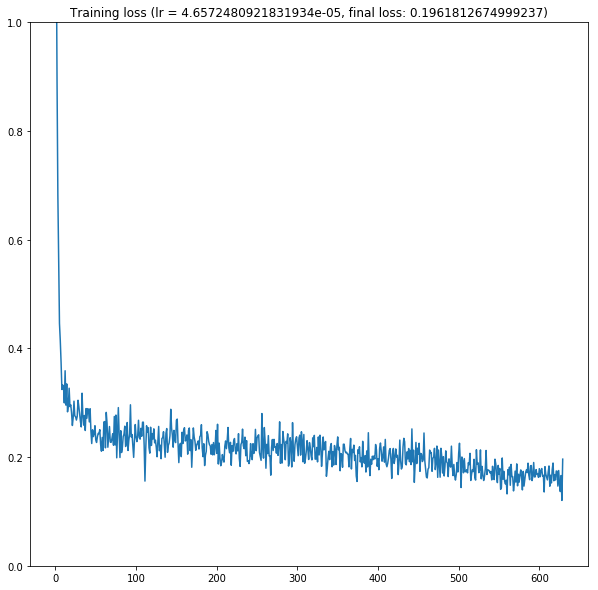

lr = 0.0001303240252000188 loss = 0.10736671090126038


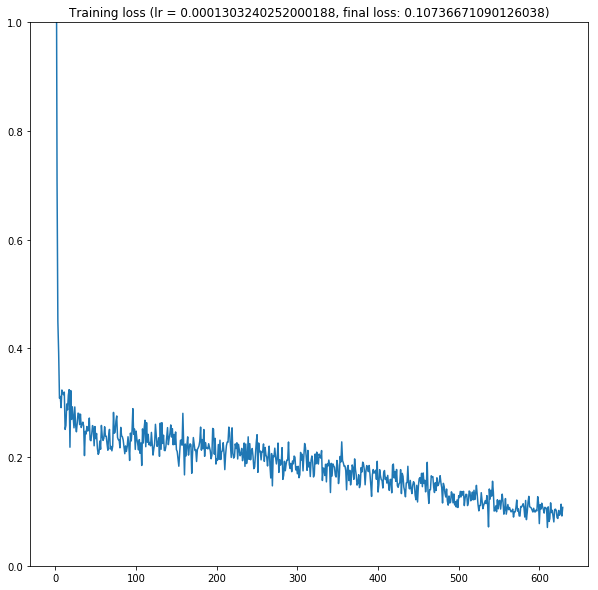

lr = 5.240839608742254e-05 loss = 0.15509037673473358


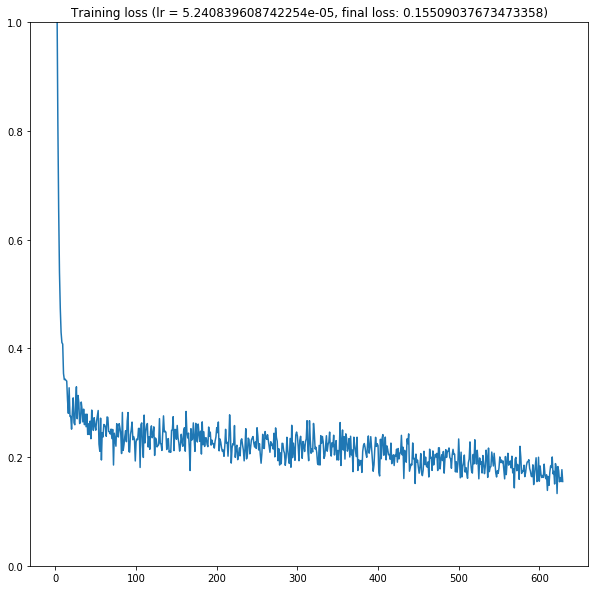

lr = 0.0007844071816646817 loss = 0.07780351489782333


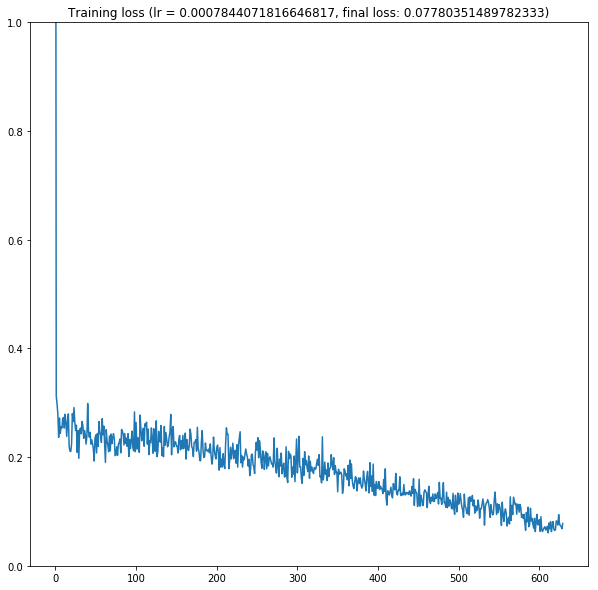

lr = 0.0005063538090939928 loss = 0.06061631813645363


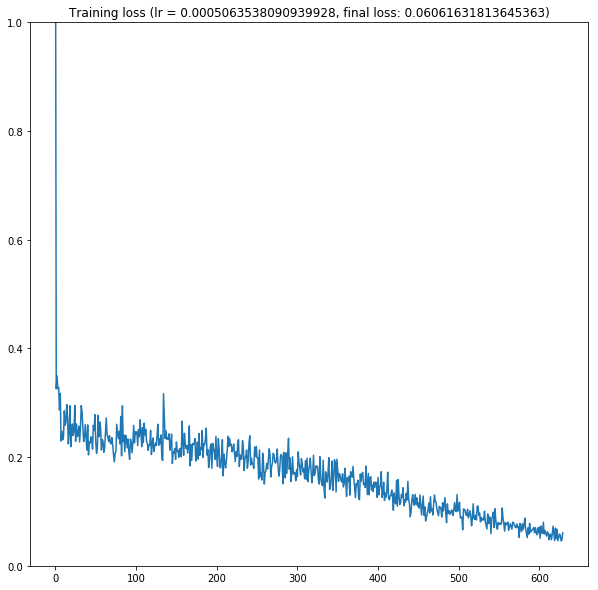

lr = 0.00010271067216944281 loss = 0.08747895061969757


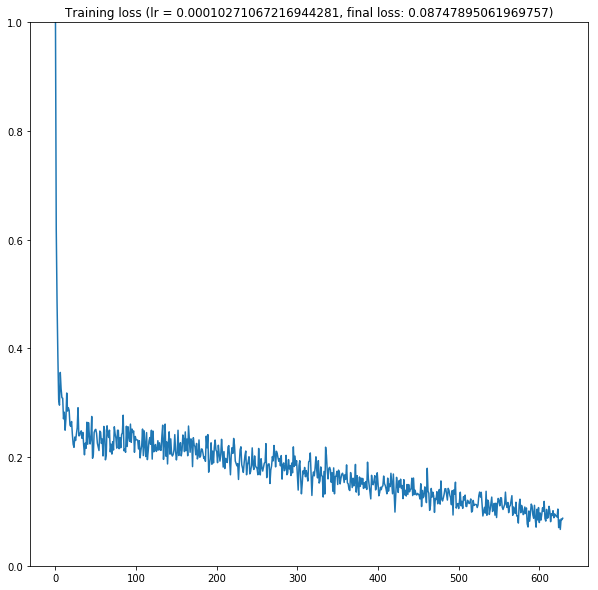

lr = 0.007258790243004042 loss = 0.22008474171161652


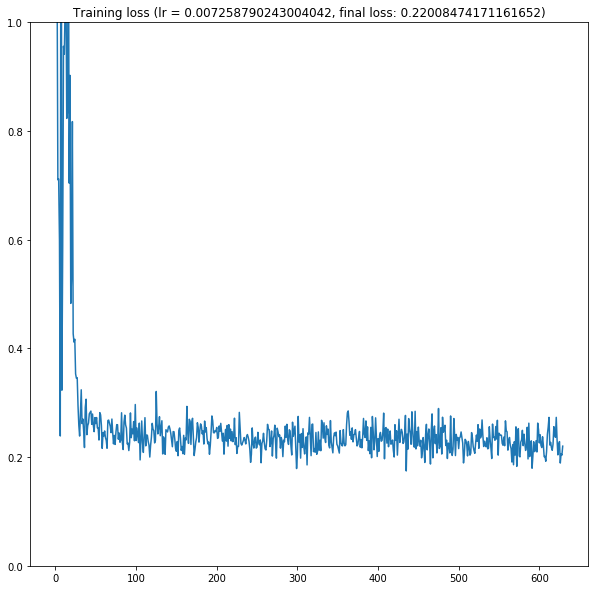

lr = 0.0003584299952240032 loss = 0.013864003121852875


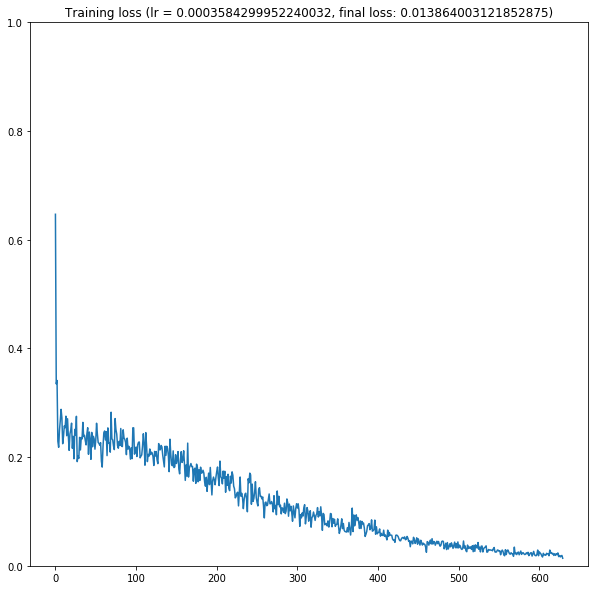

lr = 0.0023873833559301355 loss = 0.14383019506931305


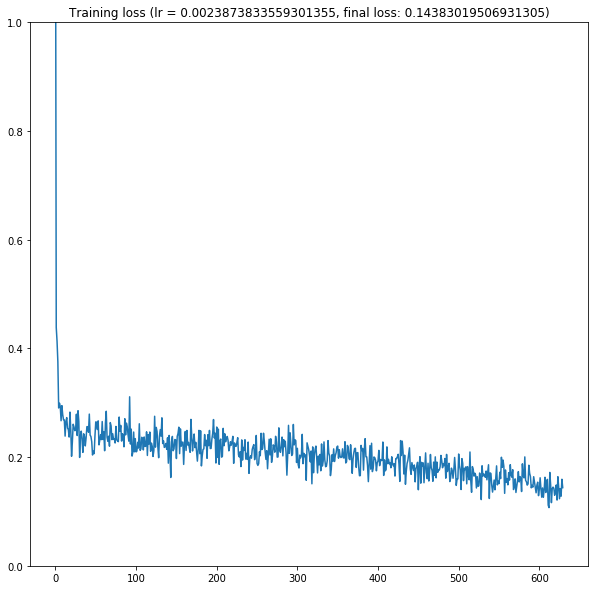

lr = 0.0011157142695375642 loss = 0.08612122386693954


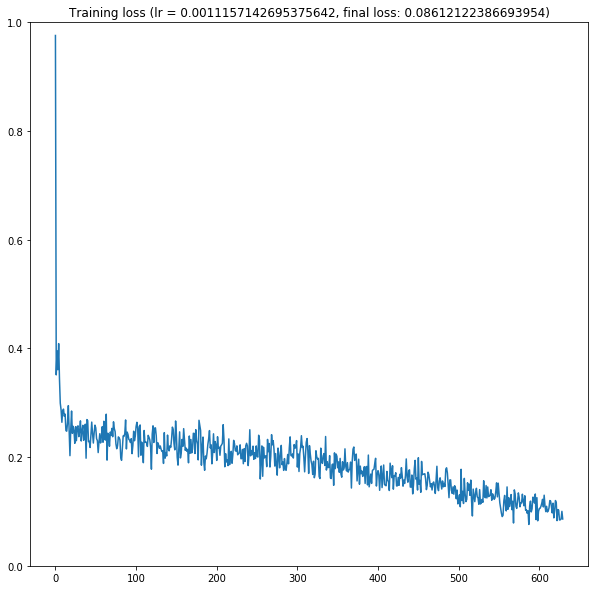

In [160]:
lrs = 10**np.random.uniform(-5, -2, 10)

points = []

for lr in lrs:
    loss_history, examples = train(model, d.train, lr, epochs=15, dtype=torch.float32, batch_size=32, verbose=False)
    points.append((lr, loss_history[-1]))
    print("lr =", lr, "loss =", loss_history[-1])
    plt.title(f"Training loss (lr = {lr}, final loss: {loss_history[-1]})")
    plt.ylim([0, 1])
    plt.plot(loss_history);
    plt.show()

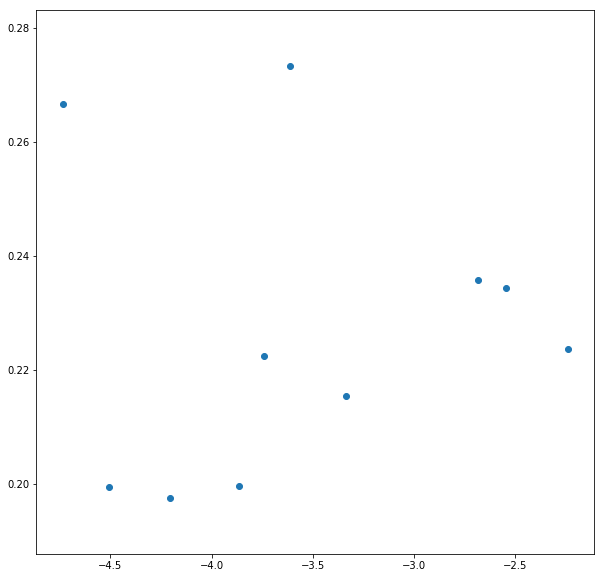

In [155]:
plt.scatter(x = np.log10([p[0] for p in points]), y = [p[1] for p in points], )

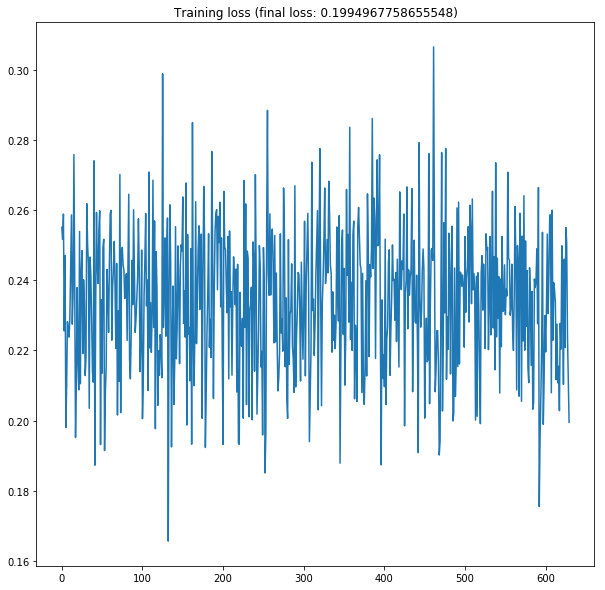

In [156]:
plt.title(f"Training loss (final loss: {loss_history[-1]})")
plt.plot(loss_history);

# Visualize predictions

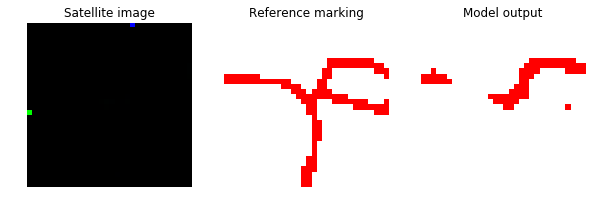

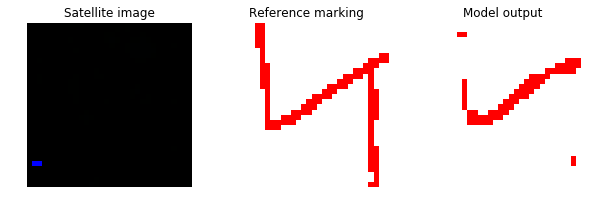

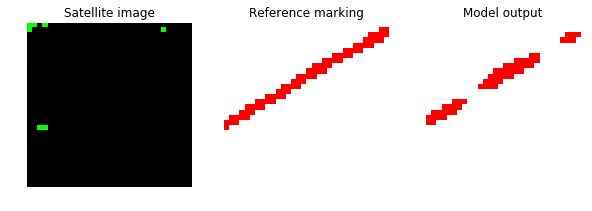

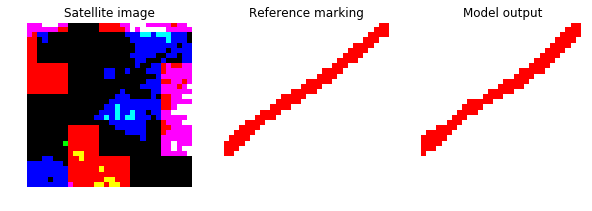

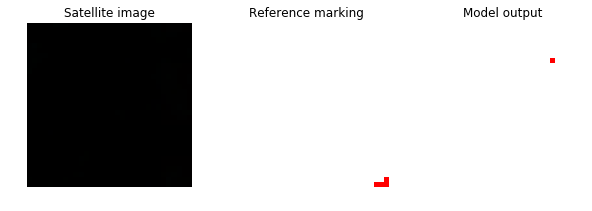

In [ ]:
EXAMPLES = 16
random_examples = False

model.eval()

while EXAMPLES > 0:
    if random_examples:
        idx = np.random.randint(0, len(d.train))
    else:
        idx = examples[EXAMPLES - 1]
    (x, y) = d.train[idx]
    
    if (np.array(y) == 1).sum() == 0:
        continue

    x = torch.Tensor(x.reshape(1, x.shape[0], x.shape[1], x.shape[2])).to(device=DEFAULT_DEVICE, copy=True, non_blocking=False)
    
    prediction = to_numpy(model(x).cpu())[0]
    prediction = prediction.argmax(axis=0)

    show_example(x[0].cpu(), y, prediction)
    EXAMPLES -= 1